## This Notebook does Cross Correlation from m0



## Some background reading

###### Space Weather:
- [Introduction](https://ccmc.gsfc.nasa.gov/RoR_WWW/SWREDI/2016/SpaceWeatherIntro_Bootcamp_2016.pdf)
- [Understanding space weather](https://www.sciencedirect.com/science/article/pii/S0273117715002252)

###### Particle Precipitation:
Here are a few particle precipitation resources that I believe are most valuable to start with:
- Technical details of the observations: [Redmon et al., [2017]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JA023339)
- Creating particle precipitation models from these data: [Hardy et al., [1987]](https://doi.org/10.1029/JA090iA05p04229) and [Newell et al., [2009]](https://doi.org/10.1029/2009JA014326)
- Considered the 'state of the art' model: [OVATION PRIME](https://ccmc.gsfc.nasa.gov/models/modelinfo.php?model=Ovation%20Prime)



## Imports and utility functions


In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

from sklearn import *

## Prepare data for ML exploration (read in full DB created from standard_ML_DB_preparation.ipynb)


In [2]:
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
DMSP_DATA_DIR=''
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)


In [3]:
df_cumulative.shape



(1947016, 149)

In [4]:
# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]
print( (feature_cols))
print(df_cumulative.columns)

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()
#print(numFeatures)

validation data shape = (55210, 149)
train data shape = (1838283, 149)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here
['SC_AACGM_LAT', 'ID_SC', 'sin_ut', 'cos_ut', 'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME', 'F107', 'Bz', 'By', 'Bx', 'AE', 'AL', 'AU', 'SymH', 'PC', 'vsw', 'vx', 'psw', 'borovsky', 'newell', 'F107_6hr', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'AE_6hr', 'AL_6hr', 'AU_6hr', 'SymH_6hr', 'PC_6hr', 'vsw_6hr', 'vx_6hr', 'psw_6hr', 'borovsky_6hr', 'newell_6hr', 'F107_5hr', 'Bz_5hr', 'By_5hr', 'Bx_5hr', 'AE_5hr', 'AL_5hr', 'AU_5hr', 'SymH_5hr', 'PC_5hr', 'vsw_5hr', 'vx_5hr', 'psw_5hr', 'borovsky_5hr', 'newell_5hr', 'F107_3hr', 'Bz_3hr', 'By_3hr', 'Bx_3hr', 'AE_3hr', 'AL_3hr', 'AU_3hr', 'SymH_3hr', 'PC_3hr', 'vsw_3hr', 'vx_3hr', 'psw_3hr', 'borovsky_3hr', 'newell_3hr', 'F107_1hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AE_1hr', 'AL_1hr', 'AU_1hr', 'SymH_1hr', 'PC_1hr', 'vsw_1hr'

In [5]:
%matplotlib inline  
import matplotlib.pyplot as plt


In [6]:
df_val.cov();

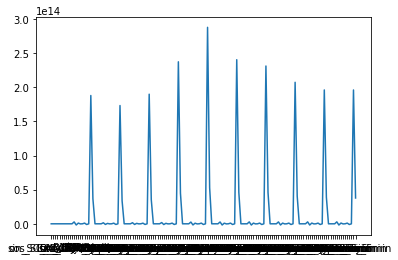

In [7]:
plt.figure()
cov = df_val.cov()
plt.plot(cov['ELE_TOTAL_ENERGY_FLUX'][2:])

In [8]:
scaler = preprocessing.RobustScaler()
scaler =scaler.fit(df_cumulative.values)
vals_scaled = scaler.transform(df_cumulative)


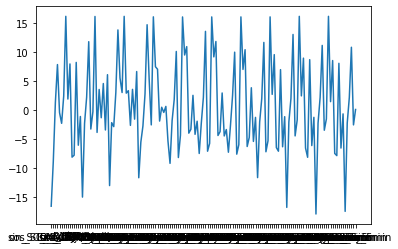

In [9]:
vals_scaled =  pd.DataFrame (vals_scaled, columns = df_val.columns)
cov=vals_scaled.cov();
plt.plot(cov['ELE_TOTAL_ENERGY_FLUX'][2:])

In [22]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

vals_scaled.corr(method=histogram_intersection);

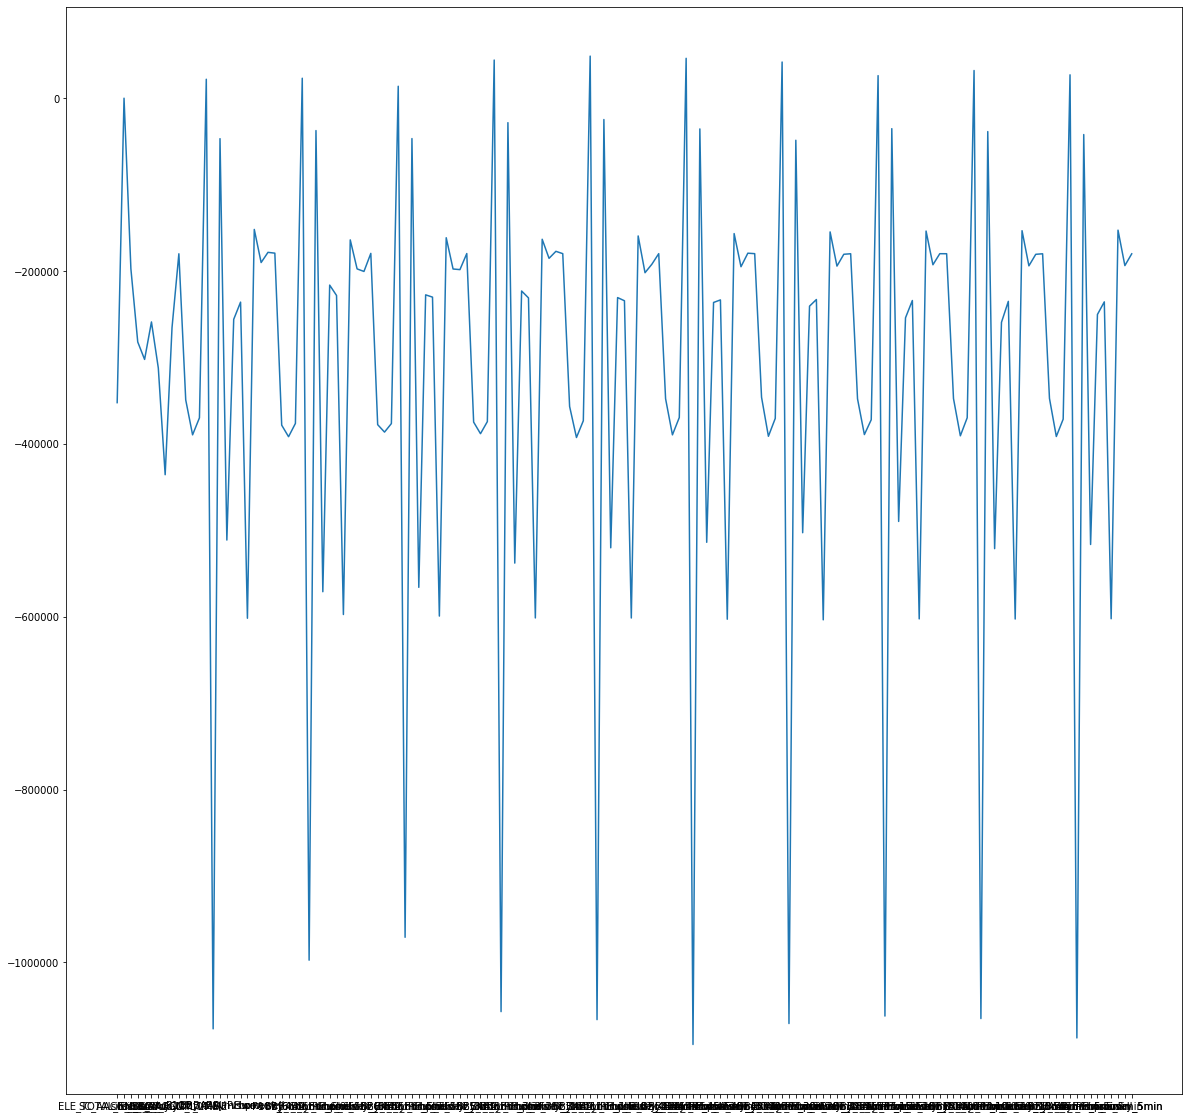

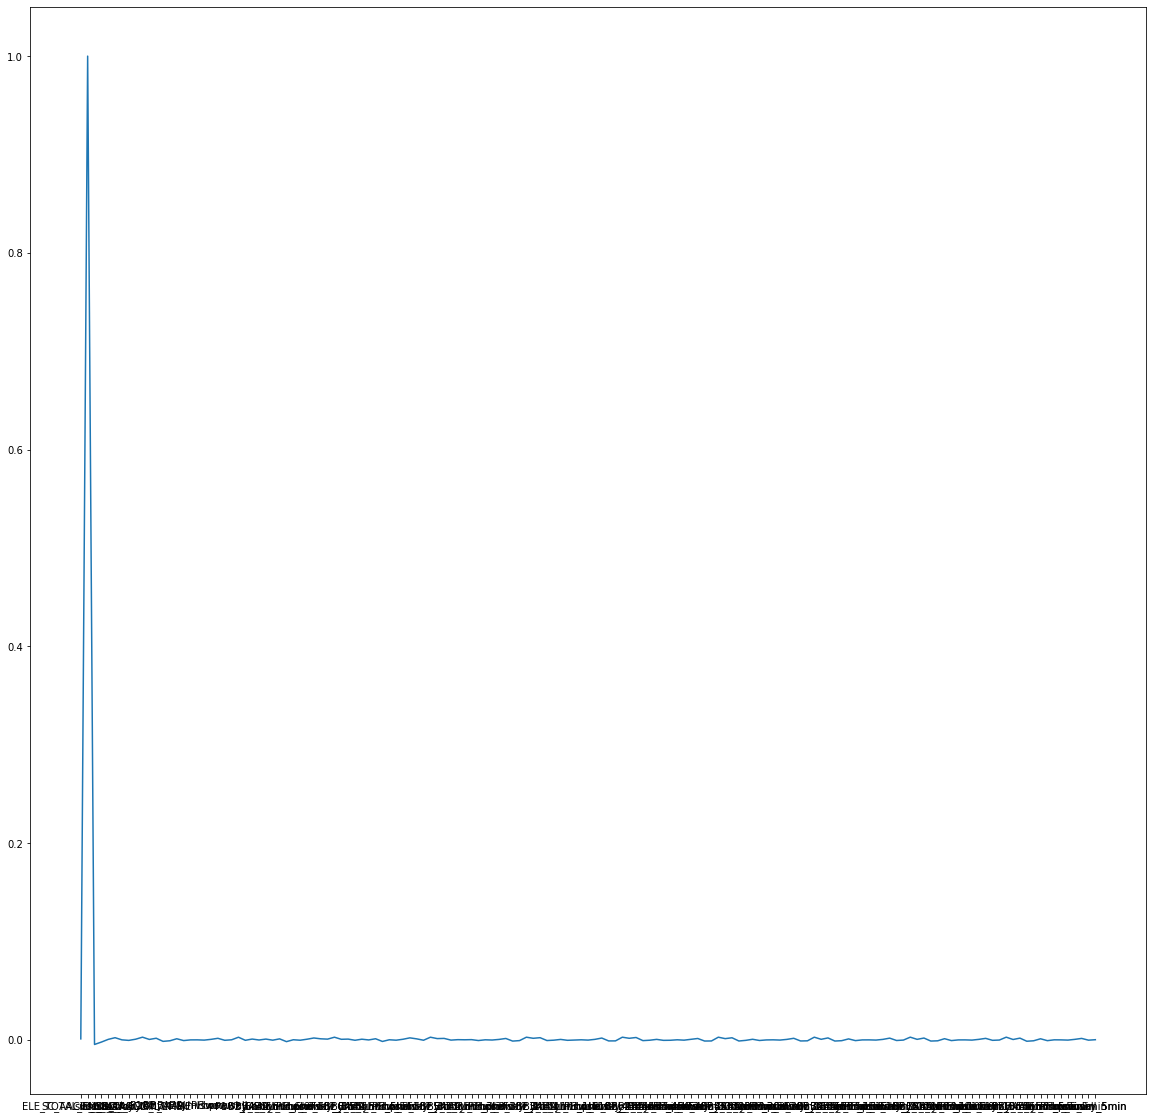

In [13]:
plt.figure(figsize=(20,20))
corr = vals_scaled.corr(method=histogram_intersection)
plt.plot(corr['ELE_TOTAL_ENERGY_FLUX'])

plt.figure(figsize=(20,20))
corr = vals_scaled.corr(method='pearson')
plt.plot(corr['ELE_TOTAL_ENERGY_FLUX'])

In [14]:
y=np.array(vals_scaled['ELE_TOTAL_ENERGY_FLUX'],dtype=np.float32)
x=np.array(vals_scaled[['SC_AACGM_LAT',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell']].copy(deep=True),dtype=np.float32)
x= np.transpose(x)

In [15]:
sum_y_squared = np.sum(y*y)
sum_x_squared = np.zeros((x.shape[0]),np.float32)
corr_zero_lag = np.zeros((x.shape[0]),np.float32)
for i in range(0,21):
    sum_x_squared[i] = np.sum(x[i,:]*x[i,:])
    corr_zero_lag[i]=np.array(np.correlate(x[i,:],y)/np.sqrt(sum_x_squared[i]*sum_y_squared),dtype=np.float32)
    


In [16]:
x.shape

(21, 1947016)

In [17]:
# xxx=np.array([1,2,3,4,5,6])
# print(np.roll(xxx,1))
# print(np.roll(xxx,0))
names=['SC_AACGM_LAT', 'sin_ut', 'cos_ut', 'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME',
  'F107', 'Bz', 'By', 'Bx', 'AE', 'AL', 'AU', 'SymH', 'PC', 'vsw', 'vx', 'psw', 'borovsky', 'newell'];

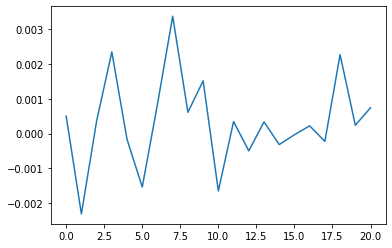

In [18]:
plt.plot(corr_zero_lag)

In [19]:
sum_y_squared = np.sum(y*y)
sum_x_squared = np.zeros((x.shape[0]),np.float32)
cross_cor = np.zeros((x.shape[0],2400),np.float32)
for i in range(0,21):
    sum_x_squared[i] = np.sum(x[i,:]*x[i,:])
    
for i in range(0,21):
    for j in range(0,cross_cor.shape[1]):
        cross_cor[i,j]=np.array(np.correlate(np.roll(x[i,:],j),y)/np.sqrt(sum_x_squared[i]*sum_y_squared),dtype=np.float32)
    

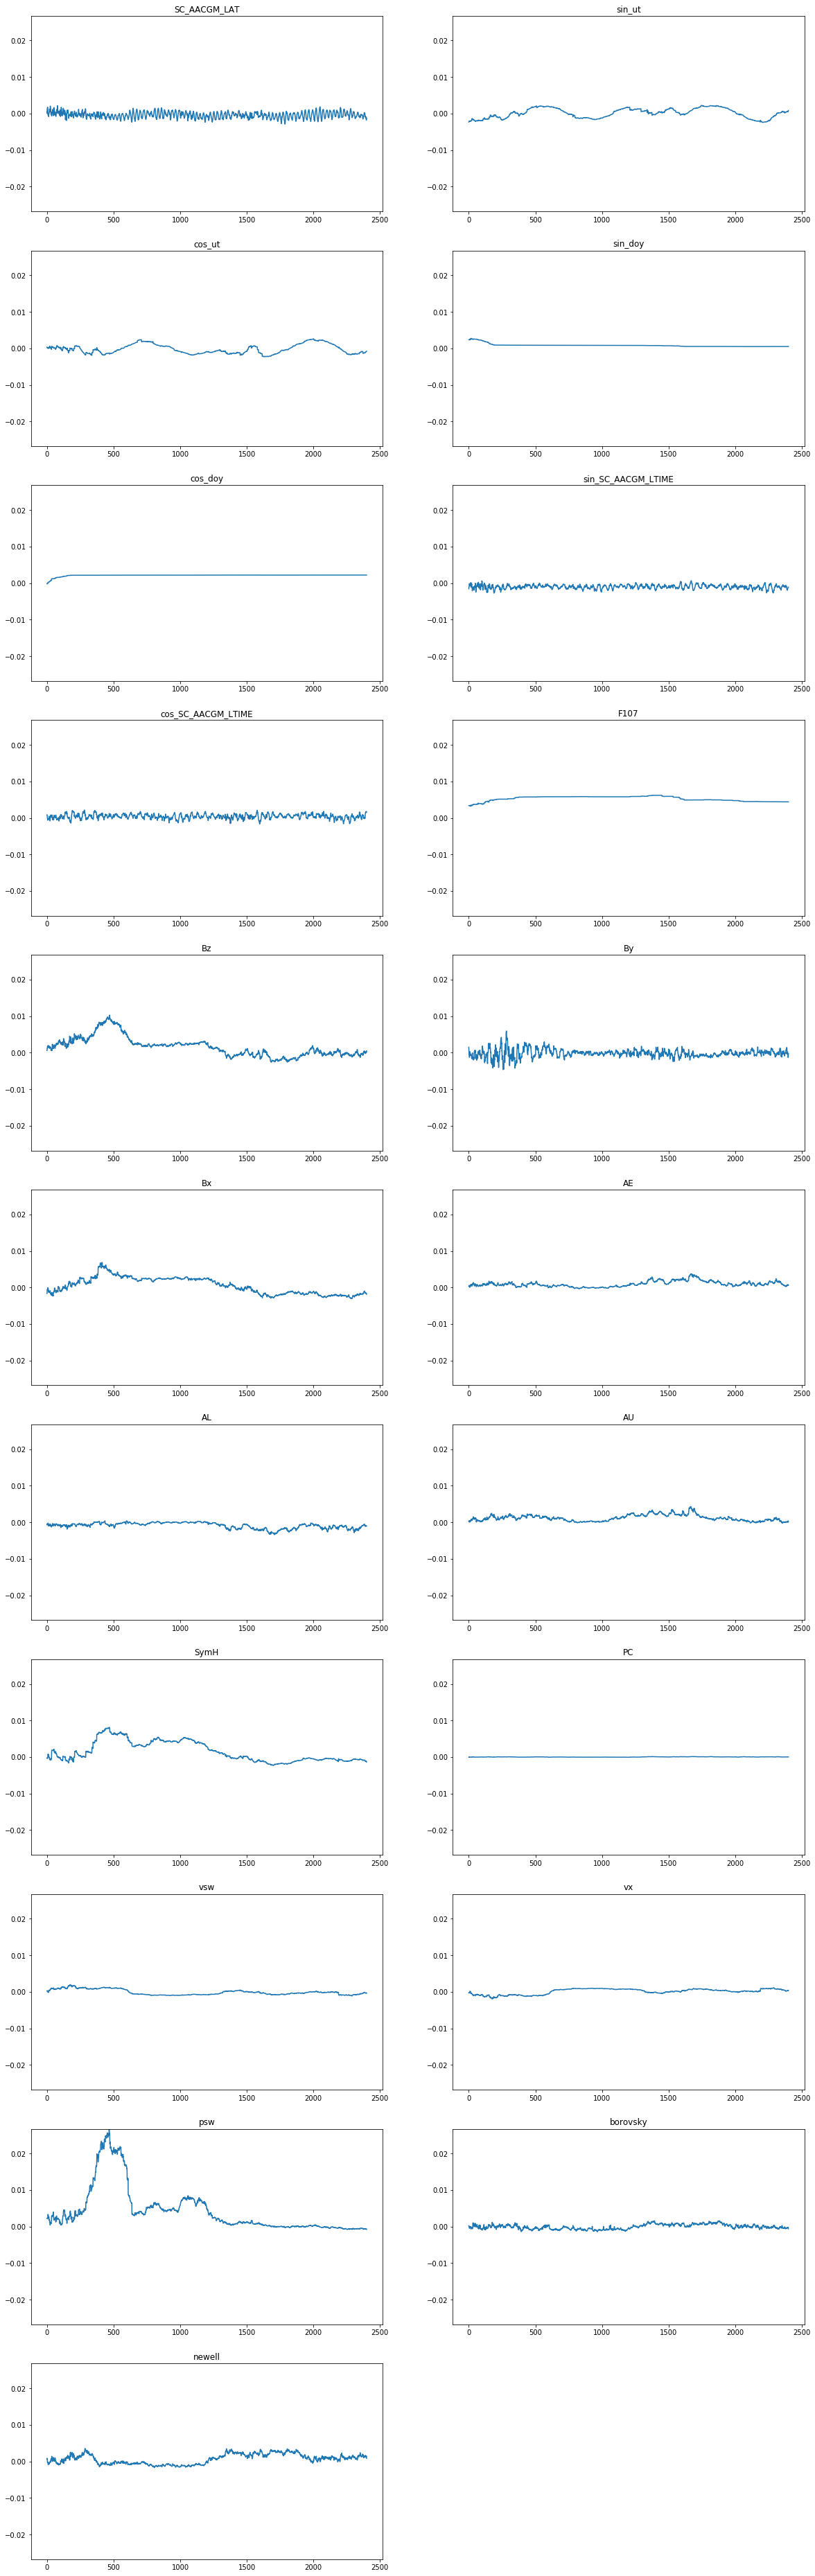

In [20]:
fig = plt.figure(figsize=(20,80))
figscale= np.max(np.max(cross_cor))
for i in range(0,21):
    plt.subplot(13,2,int(i+1))     
    plt.plot(cross_cor[i,:])
    plt.title(names[i])
    plt.ylim(-figscale,figscale)


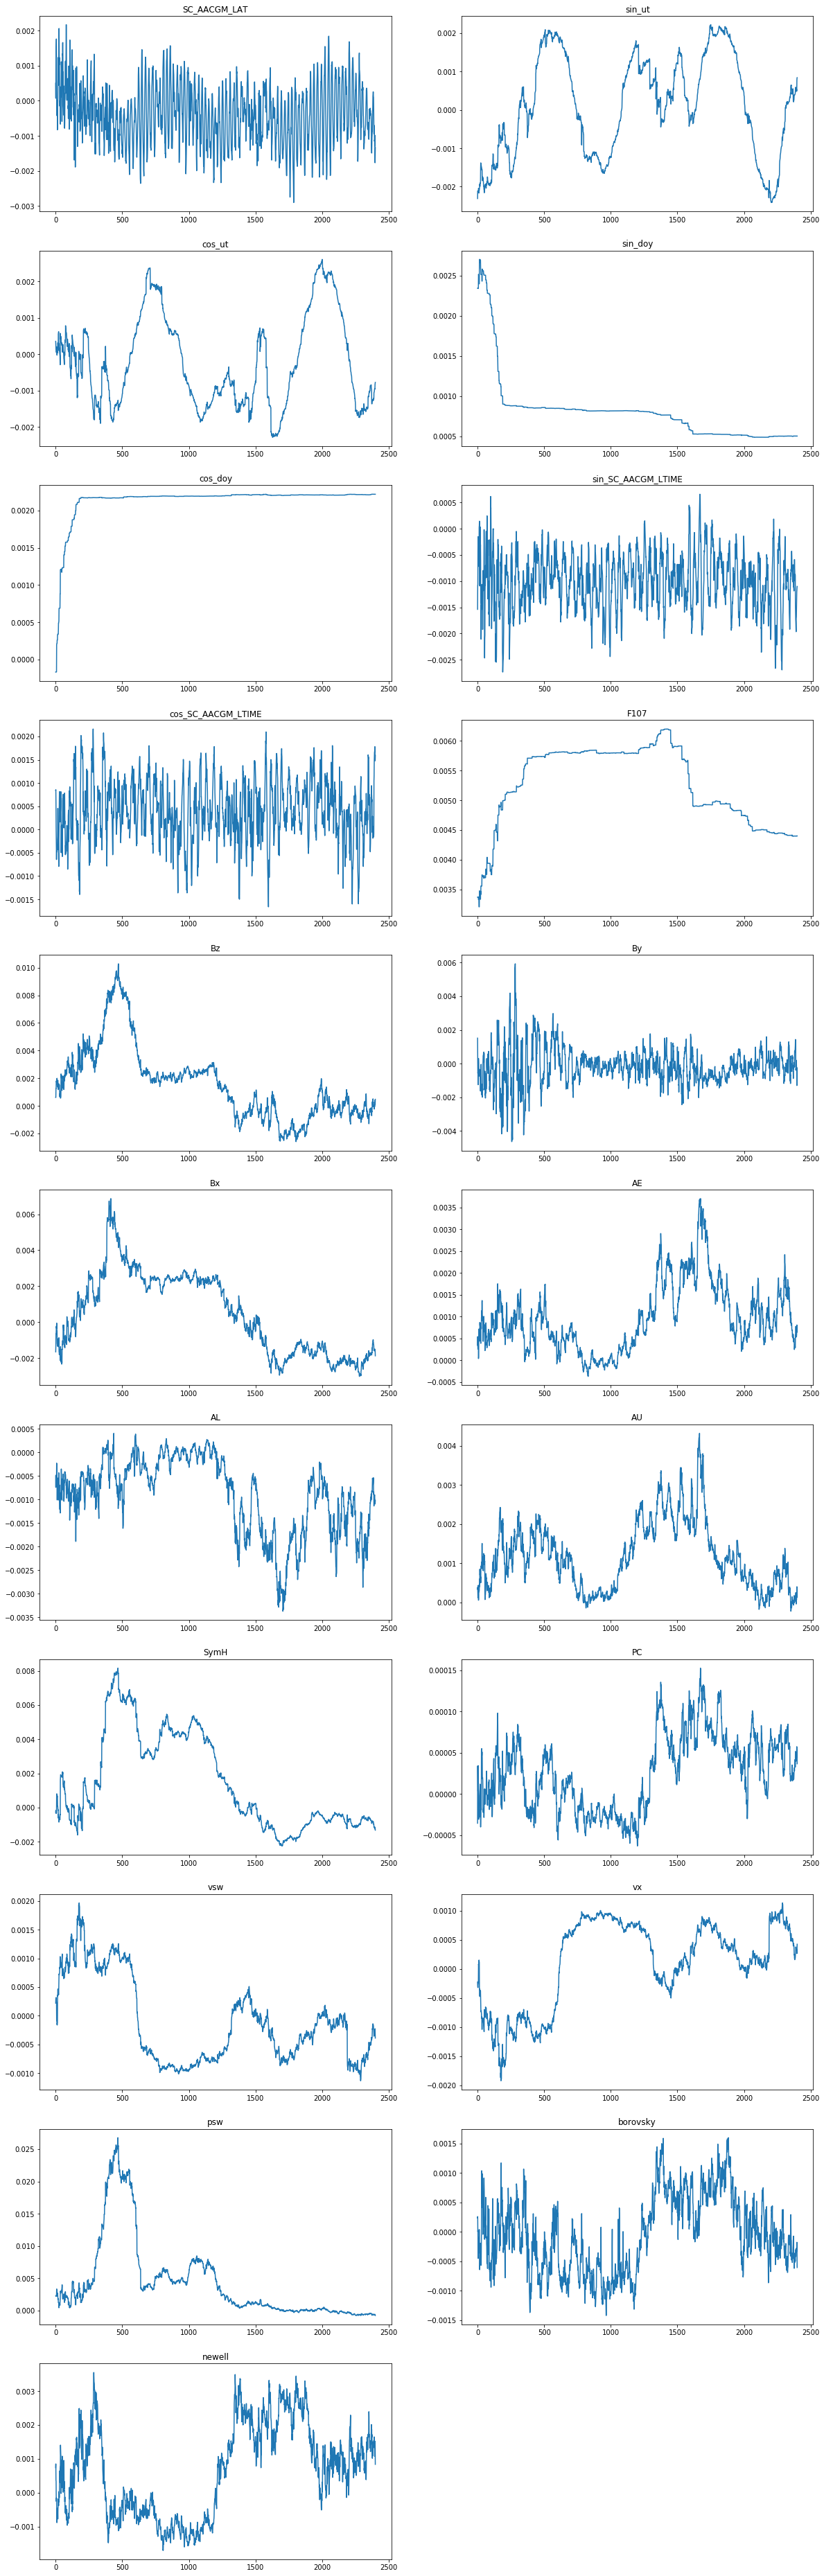

In [21]:
fig = plt.figure(figsize=(20,80))
for i in range(0,21):
    plt.subplot(13,2,int(i+1))     
    plt.plot(cross_cor[i,:])
    plt.title(names[i])